In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score
import random

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
#sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
#sample2['binned_age'] = sample2['binned_age']+0.5
#df_female = pd.concat([sample,sample2])
df_female = sample.copy()
df_female.rename(columns={'binned_age': 'age'}, inplace=True)
df_female.set_index(['age', 'mouse'], inplace=True)


In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
#df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [6]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
df_indv=f_df.groupby(['mouse','age']).mean()
df_indv = np.log(df_indv + 1e-6) #log transform

In [8]:
## get data to test on - all mice that have the last final 5 datapints:
#create test data - average of the 5 final data point of each mouse
nend=8
xtrain=pd.DataFrame()
df=df_indv.copy()

# Identify the last 3 ages
last_5_ages = df.index.get_level_values('age').unique()[-nend:]

# Filter the DataFrame to include only the last 5 ages
last_5_df = df[df.index.get_level_values('age').isin(last_5_ages)]

xtrain = df[df.index.get_level_values('age').isin(last_5_ages)]
ytrain = xtrain.index.get_level_values('mouse').to_numpy()

In [9]:
# choose a model
clf = svm.SVC(kernel='linear') 

# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=100

In [10]:
clf.fit(xtrain, ytrain)
coefficients_list=np.mean(clf.coef_,axis=0)

In [11]:
## predict ages on every

In [12]:
df=df_indv.copy()
df= df[~df.index.get_level_values('age').isin(last_5_ages)].reset_index()

In [13]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
pl = sns.color_palette("dana", n_colors=50)

/tmp/ipykernel_29378/1691959703.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)


In [14]:
xmale = pd.DataFrame()
a = 0
n = 8  # size of sliding window
age = []
acc = []
sh_acc = []
sh_ages = []
coefficients_list = []

while True:
    # Build the current age matrix
    for m, _df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale, xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].size()
    keep_mice = list(rep_counts[rep_counts >= n].index)  # keep mice that have at least nmin sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    
    ymale = xmale['mouse']
    x = xmale.drop(['mouse', 'age'], axis=1).to_numpy()
    
    # Fit the model and collect coefficients    
    # Predict labels for the test data
    y_pred = clf.predict(x)

    # Calculate accuracy score
    accuracy = accuracy_score(ymale, y_pred)

    acc.append(accuracy)
    
    # Shuffle labels and calculate shuffled accuracy
    for i in tqdm(range(it)):
        ysh_temp = np.random.permutation(ymale)
        y_pred_temp = cross_val_score(clf, x, ysh_temp, cv=cv, n_jobs=-1)
        sh_acc.append(np.mean(y_pred_temp))
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))
    
    # Handle variables for the loop
    xmale = pd.DataFrame()
    a = a + 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


In [15]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age

In [16]:
format_plots()

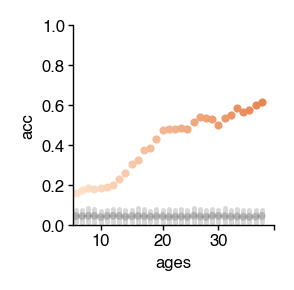

In [17]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar=('sd',2),join=True,scale=0.5)
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
sns.pointplot(data=df, x="ages", y="acc",
              dodge=0, 
              join=True, 
              ax=ax, 
              scale=0.5,
              hue='ages',
              palette=pl,
              #edgecolor='gray',
              #linewidth=0.3
             )
plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,1])
xticks = [4, 14, 23, 32]
ax.set_xticks(xticks)
sns.despine()
#ax.set_title('identity decoding in different ages bin=' + str(n))
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'longv2_id_decoder_train_on_last_data_points_female.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

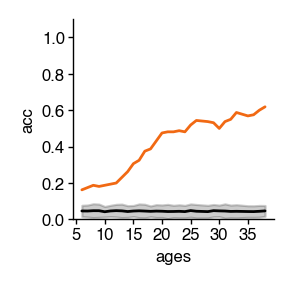

In [18]:
format_plots()
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='#f16913', estimator='mean', errorbar=('sd', 2))
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
plt.xticks([5, 10, 15, 20, 25, 30, 35])
sns.despine()
plt.show()

In [19]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'longv2_id_decoder_train_on_last_data_points_female_line.pdf')